# Python YouTube API

# 2. Data Analysis

## 2.1 Package installation and module import

In [324]:
# YouTube API packages
# pip install --upgrade google-api-python-client
# pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [325]:
# Database packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import isodate

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="darkgrid", color_codes=True)

# Env with api_key and channel_ids
from dotenv import load_dotenv
import os

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud, STOPWORDS

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


## 2.2 Data collection and preparation

In this stage of the project, I used YouTube API to gather my data. The steps I followed for are:

- First, I started the project by establishing it within the [Google Developers Console](https://console.developers.google.com/).

- Then, I applied for an authorization credential, known as an API key. I stored the API key as an environment variable called 'api_key' to protect it and prevent unauthorized use.

- Next, I activated the YouTube API for my application, enabling it to communicate with YouTube API services through API requests.

- I then proceeded to visit YouTube and retrieved the channel ID for each of the channels I intended to incorporate into my project following [this process](https://www.youtube.com/watch?v=0oDy2sWPF38&ab_channel=GaugingGadgets).

- Lastly, as seen below, I developed the necessary functions to access channel statistics via the API.

In [326]:
api_key = os.getenv('api_key')

I worked with **two DataFrames**: one for the ***channel stats***, and the other for the ***video stats***.

### 2.2.1 Channel stats

In [327]:
# List with YouTube channels: 
channel_ids = ['UCkjjH0hsvaeRIuwGlM9oSvg', # Mis Pastelitos
               'UCEwl20VxZ3AwOgiKMZtI1GQ', # La Capital
               'UCVZsY1CF9VwLTKgs9YLQkXw', # Jauja Cocina Mexicana
               'UCuGn3ioftOo6jvHE1YK4Bfw', # El Guzzi
               'UCp5tDWMJWnzmNlwurP-pDLw', # Marisolpink
               'UCJjyyWFwUIOfKhb35WgCqVg', # De mi Rancho a Tu Cocina
               'UC96WGEYgakZRuej-YI0X1Iw', # Jennifer Salas Postres
               'UCnGnDstLltFo-JpmJF1U-YQ', # RAUL BARTENDER
               'UCUAQgUTv4-OiAClB1jYTPnA' # La Ruta de la Garnacha
               ]

In [328]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
   part="snippet,contentDetails,statistics",
   id=','.join(channel_ids)
)
response = request.execute()


JSON(response)

<IPython.core.display.JSON object>

In [329]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

I used the channel_stats function defined below to bring together the channel statistics for the 9 channels in scope. As shown below, there are no NULL values. 

In [330]:
channel_stats = get_channel_stats(youtube, channel_ids)

channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Marisolpink,6080000,728879241,606,UUp5tDWMJWnzmNlwurP-pDLw
1,De mi Rancho a Tu Cocina,4320000,465264665,454,UUJjyyWFwUIOfKhb35WgCqVg
2,RAUL BARTENDER,2190000,875036482,680,UUnGnDstLltFo-JpmJF1U-YQ
3,El Guzii,6600000,1027162273,531,UUuGn3ioftOo6jvHE1YK4Bfw
4,Mis Pastelitos,14900000,2928466037,622,UUkjjH0hsvaeRIuwGlM9oSvg
5,Jauja Cocina Mexicana,8230000,1448480350,765,UUVZsY1CF9VwLTKgs9YLQkXw
6,La Ruta de la Garnacha,2100000,459598804,1184,UUUAQgUTv4-OiAClB1jYTPnA
7,Jennifer Salas Postres,3550000,387071272,953,UU96WGEYgakZRuej-YI0X1Iw
8,La Capital,9430000,2001832102,337,UUEwl20VxZ3AwOgiKMZtI1GQ


After printing the data out, I noticed that the column titles were written in CamelCase. I switched them to snake_case to make them easier to read.

In [331]:
# Rename columns (CamelCase to snake_case)
channel_column_name_mapping = {
   'channelName': 'channel_name',
   'totalVideos': 'total_videos',
   'playlistId': 'playlist_id',
}

channel_stats = channel_stats.rename(columns= channel_column_name_mapping)

channel_stats

,channel_name,subscribers,views,total_videos,playlist_id
0,Marisolpink,6080000,728879241,606,UUp5tDWMJWnzmNlwurP-pDLw
1,De mi Rancho a Tu Cocina,4320000,465264665,454,UUJjyyWFwUIOfKhb35WgCqVg
2,RAUL BARTENDER,2190000,875036482,680,UUnGnDstLltFo-JpmJF1U-YQ
3,El Guzii,6600000,1027162273,531,UUuGn3ioftOo6jvHE1YK4Bfw
4,Mis Pastelitos,14900000,2928466037,622,UUkjjH0hsvaeRIuwGlM9oSvg
5,Jauja Cocina Mexicana,8230000,1448480350,765,UUVZsY1CF9VwLTKgs9YLQkXw
6,La Ruta de la Garnacha,2100000,459598804,1184,UUUAQgUTv4-OiAClB1jYTPnA
7,Jennifer Salas Postres,3550000,387071272,953,UU96WGEYgakZRuej-YI0X1Iw
8,La Capital,9430000,2001832102,337,UUEwl20VxZ3AwOgiKMZtI1GQ


#### Channel data pre-processing

#### Data types
Then, I noticed that all the data types were in string format. I converted the figure columns into numeric to be able to make numeric operations and data visualizations.

In [332]:
# Get data types
channel_stats.dtypes

channel_name    object
subscribers     object
views           object
total_videos    object
playlist_id     object
dtype: object

In [333]:
# Convert count columns to numeric
channel_numeric_cols = ['subscribers', 'views', 'total_videos']
channel_stats[channel_numeric_cols] = channel_stats[channel_numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [334]:
# Verify data types
channel_stats.dtypes

channel_name    object
subscribers      int64
views            int64
total_videos     int64
playlist_id     object
dtype: object

#### Channel Exploratory Data Analysis

To quickly compare the subscribers from each channel, I made a graph plot.

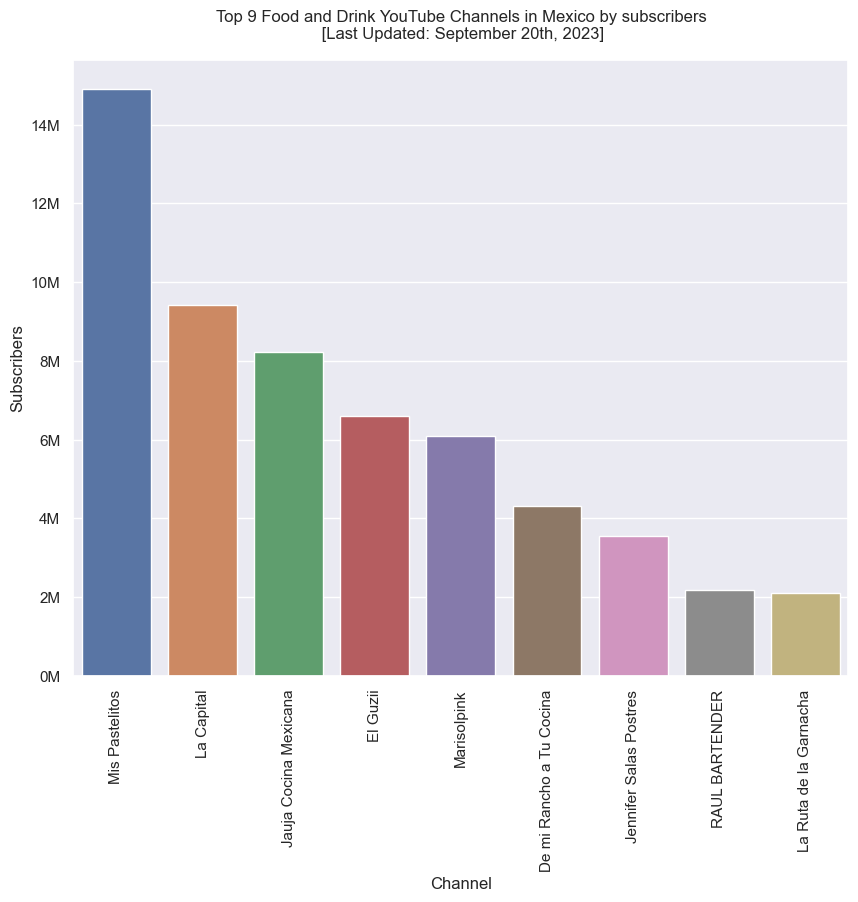

In [335]:
# Subscribers graph plot
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channel_name', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))

# Format for the 'x' and 'y' axis
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1_000_000) + 'M'))

# Title and labels
ax.set_xlabel('Channel')
ax.set_ylabel('Subscribers')
plt.title("Top 9 Food and Drink YouTube Channels in Mexico by subscribers\n [Last Updated: September 20th, 2023]", pad= 15);

Then, I made a graph plot to take a look at the total number of views from each channel. At first glance, the rank looks similar in both graphs as *Mis Pastelitos*, *La Capital*, *Jauja Cocina Mexicana* and *El Guzzi* remain in the same positions. 

However, it is worth mentioning that some channels rank higher in subscribers but have fewer total views, and vice versa. For instance, *Marisolpink* boasts a substantially larger subscriber base than *RAUL BARTENDER* but slightly fewer overall views

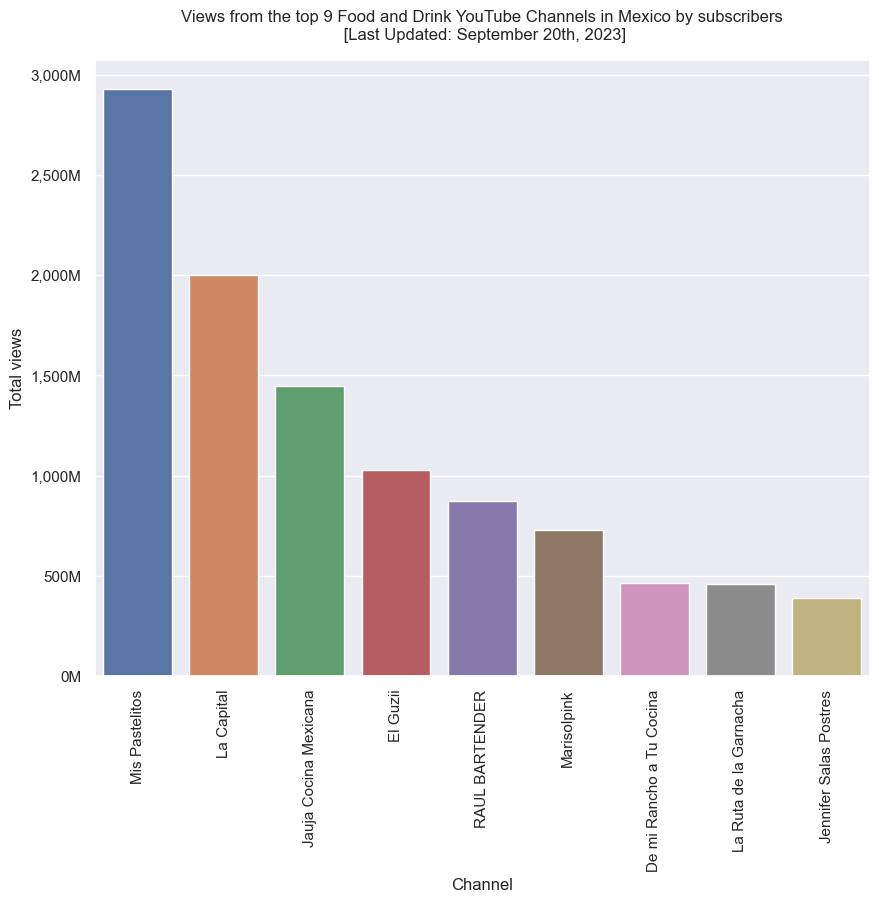

In [336]:
# Views graph plot
ax = sns.barplot(x='channel_name', y='views', data=channel_stats.sort_values('views', ascending=False))

# Format for the 'x' and 'y' axis
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1_000_000) + 'M'))

# Title and labels
ax.set_xlabel('Channel')
ax.set_ylabel('Total views')
plt.title("Views from the top 9 Food and Drink YouTube Channels in Mexico by subscribers\n [Last Updated: September 20th, 2023]", pad= 15);

### 2.2.2 Video stats

I used the 'playlist_id' values from the 'channel_stats' DataFrame to build a new DataFrame with the stats from each video of the 9 channels. With the first function, I got each video id. With the second one, I got the details for each video.

In [337]:
def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [338]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

I used the for loop function below to obtain the video statistics for all the videos and append them in the *video_df* DataFrame

In [339]:
# Create a dataframe with video statistics from all channels

video_df = pd.DataFrame()

for c in channel_stats['channel_name'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_stats.loc[channel_stats['channel_name']== c, 'playlist_id'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    
    video_df = video_df.append(video_data, ignore_index=True)

Getting video information from channel: Marisolpink
Getting video information from channel: De mi Rancho a Tu Cocina
Getting video information from channel: RAUL BARTENDER
Getting video information from channel: El Guzii
Getting video information from channel: Mis Pastelitos
Getting video information from channel: Jauja Cocina Mexicana
Getting video information from channel: La Ruta de la Garnacha
Getting video information from channel: Jennifer Salas Postres
Getting video information from channel: La Capital


It gathered data from 6,054 videos!

In [340]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Gdb4EQq4Rfg,Marisolpink,Desmenuza el pollo en segundos #hacks #hacksde...,,None,2023-09-19T19:08:43Z,25097,2006,None,38,PT58S,hd,false
1,7MqOWxa2LFk,Marisolpink,Bento facil para lunch #bento #lunchideas #lon...,,None,2023-09-18T20:11:44Z,19902,1438,None,19,PT50S,hd,false
2,sQDFcHtqW9I,Marisolpink,Tequila con jamaica y sal ahumada #tequila #me...,,None,2023-09-16T00:19:46Z,13698,1133,None,17,PT1M1S,hd,false
3,hbKOb5I4w6M,Marisolpink,Baileys mexicano de arroz con leche #horchata ...,,None,2023-09-16T00:00:26Z,11918,1006,None,25,PT1M1S,hd,false
4,99tMEEacBG4,Marisolpink,3 cocteles de la bandera: VERDE #cocteles #mid...,,None,2023-09-15T23:35:36Z,30016,1862,None,45,PT59S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27T16:30:01Z,3779170,155053,None,3017,PT7M9S,hd,false
6050,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21T16:30:00Z,3853825,122572,None,2705,PT5M56S,hd,false
6051,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14T16:45:04Z,3883539,122353,None,5157,PT9M55S,hd,false
6052,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10T14:51:50Z,1759454,70961,None,2704,PT12M36S,hd,false


As with the *channel_stats* DataFrame, I switched the column titles to snake_case for clarity and convenience.

In [341]:
# Rename columns (CamelCase to snake_case)
video_column_name_mapping = {
   'channelTitle': 'channel_title',
   'publishedAt': 'published_at',
   'viewCount': 'view_count',
   'likeCount': 'like_count',
   'favouriteCount': 'favorite_count',
   'commentCount': 'comment_count',
}

video_df = video_df.rename(columns= video_column_name_mapping)

video_df.head()

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption
0,Gdb4EQq4Rfg,Marisolpink,Desmenuza el pollo en segundos #hacks #hacksde...,,None,2023-09-19T19:08:43Z,25097,2006,None,38,PT58S,hd,false
1,7MqOWxa2LFk,Marisolpink,Bento facil para lunch #bento #lunchideas #lon...,,None,2023-09-18T20:11:44Z,19902,1438,None,19,PT50S,hd,false
2,sQDFcHtqW9I,Marisolpink,Tequila con jamaica y sal ahumada #tequila #me...,,None,2023-09-16T00:19:46Z,13698,1133,None,17,PT1M1S,hd,false
3,hbKOb5I4w6M,Marisolpink,Baileys mexicano de arroz con leche #horchata ...,,None,2023-09-16T00:00:26Z,11918,1006,None,25,PT1M1S,hd,false
4,99tMEEacBG4,Marisolpink,3 cocteles de la bandera: VERDE #cocteles #mid...,,None,2023-09-15T23:35:36Z,30016,1862,None,45,PT59S,hd,false


### Video data pre-processing
To make use of the data effectively for the analysis, I need to execute a series of preliminary processing steps.

#### NULL and Empty values
There are NULL values in some columns. However these columns are not fundamental, as they do not seriously affect data analysis, so I'll leave them as they are.
- *tags* has NULL values because not all YouTube videos have to contain tags.
- *like_count*, *favorite_count*, and *comment_count* have NULL values. It may be due to several reasons, but one of them is that vloggers turn those features off of some videos.

In [342]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channel_title     False
title             False
description       False
tags               True
published_at      False
view_count        False
like_count         True
favorite_count     True
comment_count      True
duration          False
definition        False
caption           False
dtype: bool

In [343]:
# Verify that there are no dates with the empty video column
video_df.published_at.sort_values().value_counts()

2018-02-05T23:59:10Z    8
2015-12-30T09:30:00Z    4
2021-07-08T19:00:05Z    2
2019-01-03T22:30:00Z    2
2016-04-01T01:00:00Z    2
                       ..
2018-10-23T20:45:01Z    1
2018-10-22T21:00:00Z    1
2018-10-22T16:33:25Z    1
2018-10-19T00:43:41Z    1
2023-09-21T00:19:03Z    1
Name: published_at, Length: 6041, dtype: int64

#### Data types
Just like I did with the channel_stats DataFrame, I switched the values of the figure columns from string to numeric.

In [344]:
# Get data types
video_df.dtypes

video_id          object
channel_title     object
title             object
description       object
tags              object
published_at      object
view_count        object
like_count        object
favorite_count    object
comment_count     object
duration          object
definition        object
caption           object
dtype: object

In [345]:
# Convert count columns to numeric
video_numeric_cols = ['view_count', 'like_count', 'favorite_count', 'comment_count']
video_df[video_numeric_cols] = video_df[video_numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [346]:
# Verify data types
video_df.dtypes

video_id           object
channel_title      object
title              object
description        object
tags               object
published_at       object
view_count        float64
like_count        float64
favorite_count    float64
comment_count     float64
duration           object
definition         object
caption            object
dtype: object

#### Enriching data
In this stage, I made the following changes to the DataFrame to improve my comprehension of the dataset:
- Reformated the published_at and the duration columns.
- Added the day every video was published.
- Quantified the number of tags per video.
- Created the comments and likes per 1000 views ratio.
- Displayed the title character lenght.

In [347]:
# Convert the 'published_at' strings into a datetime objects.
video_df['published_at'] = video_df['published_at'].apply(lambda x: parser.parse(x))

In [348]:
# Published day in the week (Monday, Tuesday, ...)
video_df['published_day_name'] = video_df['published_at'].apply(lambda x: x.strftime("%A")) 

In [349]:
# Duration from days and seconds to just seconds ('timedelta64[s]')
video_df['duration_secs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))

video_df['duration_secs'] = video_df['duration_secs'].astype('timedelta64[s]')

In [350]:
# Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [351]:
# Comments and likes per 1000 view ratio
video_df['like_ratio'] = video_df['like_count']/ video_df['view_count'] * 1000
video_df['comment_ratio'] = video_df['comment_count']/ video_df['view_count'] * 1000

In [352]:
# Title character length
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))

Verified that all the changes were made effectively. Now I can proceed to the next stage.

In [353]:
video_df

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
0,Gdb4EQq4Rfg,Marisolpink,Desmenuza el pollo en segundos #hacks #hacksde...,,None,2023-09-19 19:08:43+00:00,25097.0,2006.0,NaN,38.0,PT58S,hd,false,Tuesday,58.0,0,79.929872,1.514125,99
1,7MqOWxa2LFk,Marisolpink,Bento facil para lunch #bento #lunchideas #lon...,,None,2023-09-18 20:11:44+00:00,19902.0,1438.0,NaN,19.0,PT50S,hd,false,Monday,50.0,0,72.254045,0.954678,99
2,sQDFcHtqW9I,Marisolpink,Tequila con jamaica y sal ahumada #tequila #me...,,None,2023-09-16 00:19:46+00:00,13698.0,1133.0,NaN,17.0,PT1M1S,hd,false,Saturday,61.0,0,82.712805,1.241057,100
3,hbKOb5I4w6M,Marisolpink,Baileys mexicano de arroz con leche #horchata ...,,None,2023-09-16 00:00:26+00:00,11918.0,1006.0,NaN,25.0,PT1M1S,hd,false,Saturday,61.0,0,84.410136,2.097667,99
4,99tMEEacBG4,Marisolpink,3 cocteles de la bandera: VERDE #cocteles #mid...,,None,2023-09-15 23:35:36+00:00,30016.0,1862.0,NaN,45.0,PT59S,hd,false,Friday,59.0,0,62.033582,1.499200,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3779170.0,155053.0,NaN,3017.0,PT7M9S,hd,false,Saturday,429.0,25,41.028321,0.798323,53
6050,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3853825.0,122572.0,NaN,2705.0,PT5M56S,hd,false,Sunday,356.0,19,31.805284,0.701900,45
6051,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3883539.0,122353.0,NaN,5157.0,PT9M55S,hd,false,Sunday,595.0,13,31.505542,1.327913,41
6052,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1759454.0,70961.0,NaN,2704.0,PT12M36S,hd,false,Wednesday,756.0,19,40.331262,1.536840,83


### Video Exploratory Data Analysis
With access to video statistics for all channels, I am now discern distinct patterns, such as:
- How are views distributed across each channel?
- Does the number of likes and comments influence a video's view count?
- Does video length have an impact on views and engagement (likes/comments)?
- Does title lenght influence views?
- What are the words most commonly used in the titles?
- How many tags do most videos have?
- What are the most common days to upload a video?

#### View distribution (Views per each video) 

Some channels exhibit significant disparities in views among their videos, with a few viral videos garnering substantial attention while the rest receive fewer views. 
- Mis Pastelitos
- RAUL BARTENDER
- La Capital

In contrast, certain channels showcase less views in general, but a more even distribution of views across their content.
- La Ruta de la Garnacha
- De mi Rancho a Tu Cocina

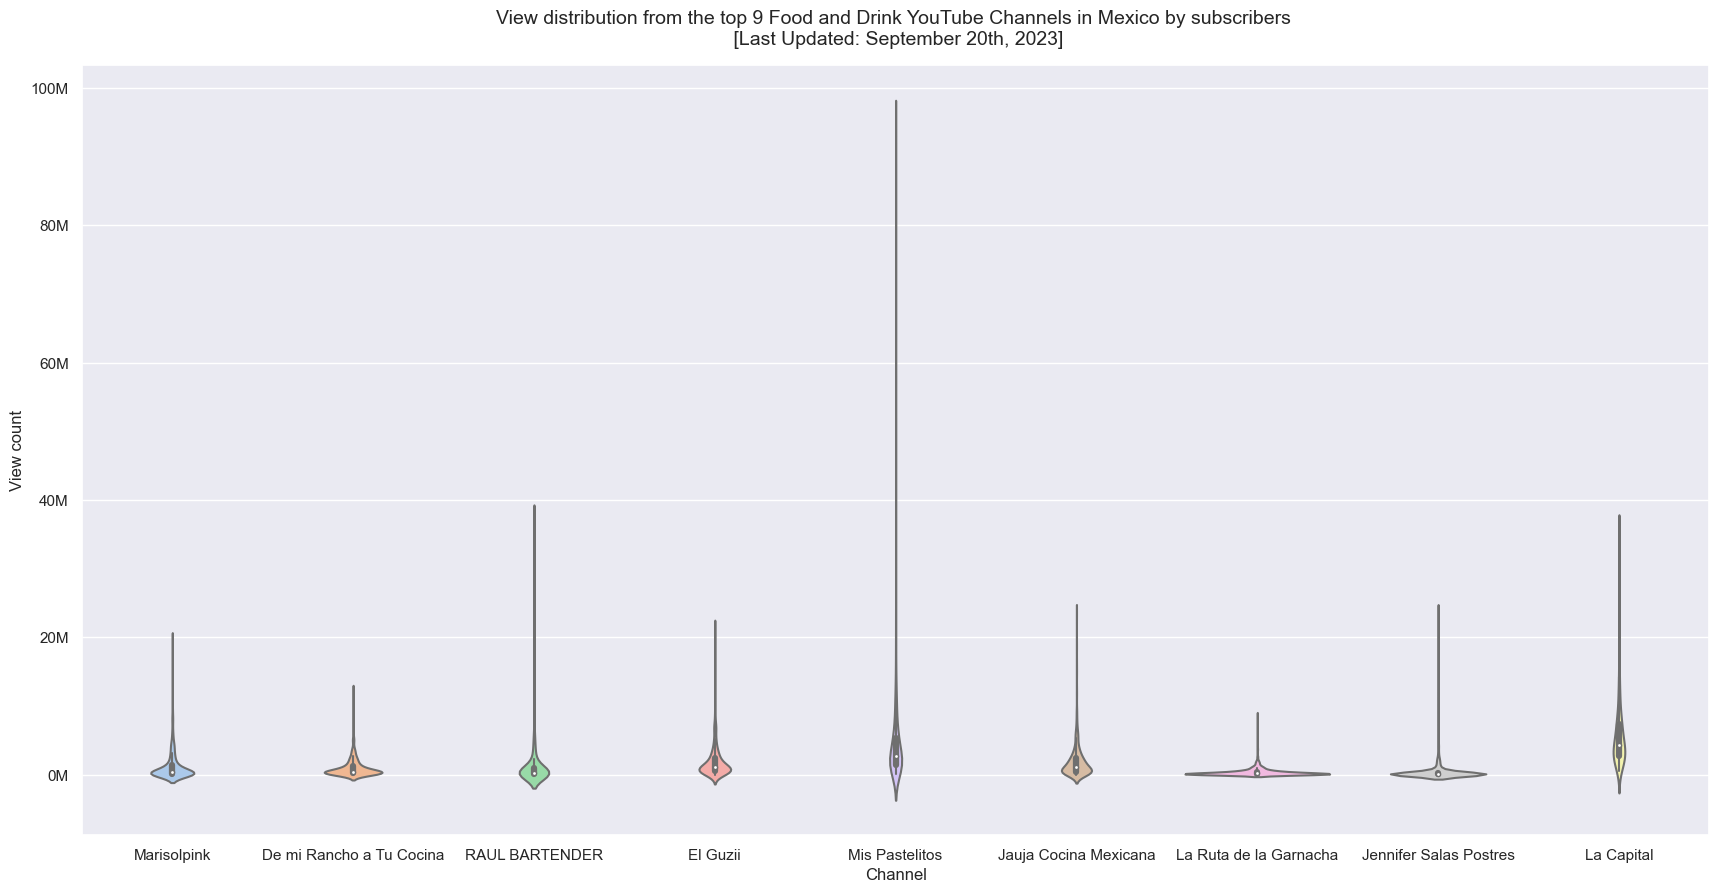

In [354]:
# View distribution violin plot
plt.rcParams['figure.figsize'] = (21, 10)
ax= sns.violinplot(x= video_df['channel_title'], y= video_df['view_count'], palette = 'pastel')

# Format for the 'y' axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'))

# Title and labels
ax.set_xlabel('Channel')
ax.set_ylabel('View count')
plt.title("View distribution from the top 9 Food and Drink YouTube Channels in Mexico by subscribers \n [Last Updated: September 20th, 2023]", fontsize = 14, pad= 15);

#### Correlation between views and the number of comments/likes
The plots below reveal a strong positive correlation between the number of views and both comments and likes. In particular, the number of likes demonstrates a stronger correlation compared to comments, which is an expected pattern. A possible explanation is that likes are less time-consuming than comments.

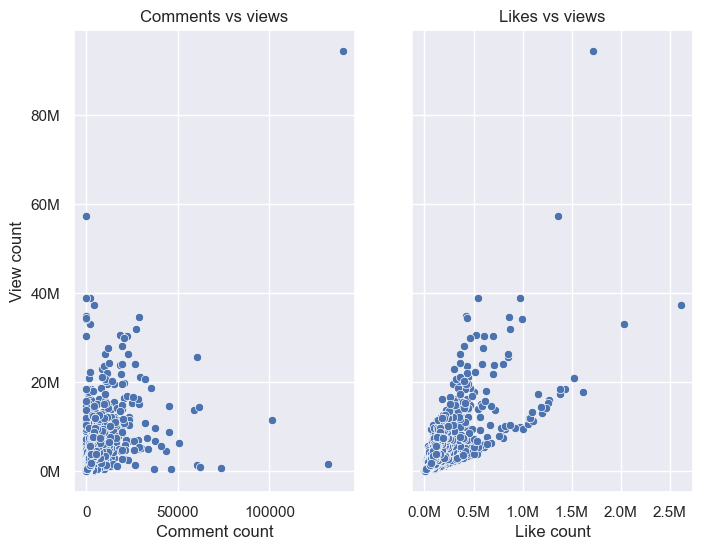

In [355]:
# Create figures
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

# Like and comment count vs view count scatter plots
sns.scatterplot(data = video_df, x = 'comment_count', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_count', y = 'view_count', ax = ax[1])

# Titles and labels
ax[0].set(xlabel='Comment count', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like count', ylabel='View count', title='Likes vs views')

# Formats for the 'x' axis in the ax[1] and the 'y' shared axis
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'))
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

To confirm the above, I calculated the numeric correlations and indeed: both are positive, and the like count one is higher than the comment count. 

In [356]:
print(f"The correlation between the number of comments and the view count is: {video_df['comment_count'].corr(video_df['view_count'])}")
print(f"The correlation between the number of likes and the view count is: {video_df['like_count'].corr(video_df['view_count'])}")

The correlation between the number of comments and the view count is: 0.553709311489322
The correlation between the number of likes and the view count is: 0.7969491073032423


Then, I refined the analysis by plotting the relationships using ratios (likes and comments per 1000 views), rather than absolute numbers. This adjustment allows to better assess the impact of comments and likes on viewership, accounting for the video's popularity.

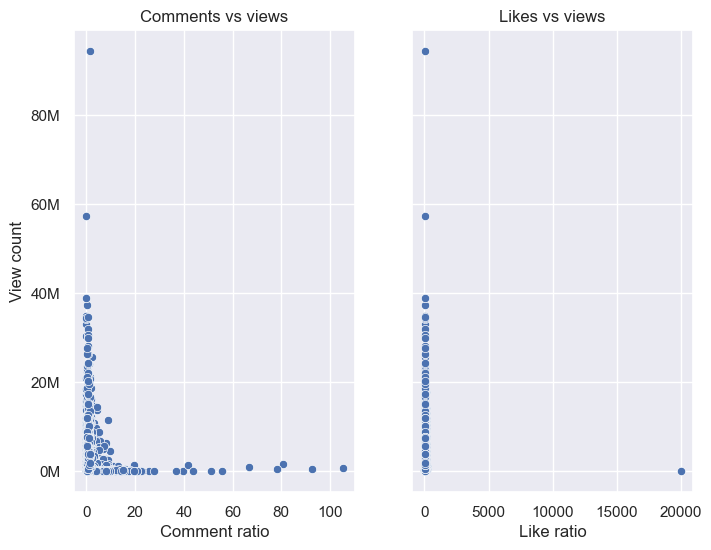

In [357]:
# Create figures
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

# Like and comment ratio vs view count scatter plots
sns.scatterplot(data = video_df, x = 'comment_ratio', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_ratio', y = 'view_count', ax = ax[1])

# Titles and labels
ax[0].set(xlabel='Comment ratio', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like ratio', ylabel='View count', title='Likes vs views')

# Format for the shared 'y' axis
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

From the 'Likes vs views' plot above, it seems that there are outlier values that may distort the graph. For example, the highest value of *like_ratio* very unlikely, as it suggests that a video can have 20,000 likes per 1,000 views.

In [358]:
video_df[video_df['like_ratio'] > 10_000]

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
64,wbSnL788Aus,Marisolpink,●EN VIVO● Marisolpink Pollo al vinoblanco y CH...,Hoy vamos a cocinar un pollo en crema de vino ...,None,2023-05-05 01:58:57+00:00,0.0,18.0,NaN,0.0,P0D,sd,false,Friday,0.0,0,inf,NaN,77
2031,sXxbEUYuJ0Q,El Guzii,El Guzii Live Stream,,None,2017-03-10 09:14:30+00:00,1.0,20.0,NaN,0.0,P0D,sd,false,Friday,0.0,0,20000.0,0.0,20
5497,W0aILvM_CSs,Jennifer Salas Postres,Transmisión en directo de Jennifer Salas Postres,,None,2019-04-10 00:25:59+00:00,0.0,2.0,NaN,0.0,P0D,sd,false,Wednesday,0.0,0,inf,NaN,48


In [359]:
# Drop 'like_ratio' outliers
drop_rows = video_df[video_df['like_ratio'] > 10_000].index

video_df = video_df.drop(drop_rows, axis=0)

video_df = video_df.reset_index(drop=True)

video_df


,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
0,Gdb4EQq4Rfg,Marisolpink,Desmenuza el pollo en segundos #hacks #hacksde...,,None,2023-09-19 19:08:43+00:00,25097.0,2006.0,NaN,38.0,PT58S,hd,false,Tuesday,58.0,0,79.929872,1.514125,99
1,7MqOWxa2LFk,Marisolpink,Bento facil para lunch #bento #lunchideas #lon...,,None,2023-09-18 20:11:44+00:00,19902.0,1438.0,NaN,19.0,PT50S,hd,false,Monday,50.0,0,72.254045,0.954678,99
2,sQDFcHtqW9I,Marisolpink,Tequila con jamaica y sal ahumada #tequila #me...,,None,2023-09-16 00:19:46+00:00,13698.0,1133.0,NaN,17.0,PT1M1S,hd,false,Saturday,61.0,0,82.712805,1.241057,100
3,hbKOb5I4w6M,Marisolpink,Baileys mexicano de arroz con leche #horchata ...,,None,2023-09-16 00:00:26+00:00,11918.0,1006.0,NaN,25.0,PT1M1S,hd,false,Saturday,61.0,0,84.410136,2.097667,99
4,99tMEEacBG4,Marisolpink,3 cocteles de la bandera: VERDE #cocteles #mid...,,None,2023-09-15 23:35:36+00:00,30016.0,1862.0,NaN,45.0,PT59S,hd,false,Friday,59.0,0,62.033582,1.499200,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3779170.0,155053.0,NaN,3017.0,PT7M9S,hd,false,Saturday,429.0,25,41.028321,0.798323,53
6047,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3853825.0,122572.0,NaN,2705.0,PT5M56S,hd,false,Sunday,356.0,19,31.805284,0.701900,45
6048,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3883539.0,122353.0,NaN,5157.0,PT9M55S,hd,false,Sunday,595.0,13,31.505542,1.327913,41
6049,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1759454.0,70961.0,NaN,2704.0,PT12M36S,hd,false,Wednesday,756.0,19,40.331262,1.536840,83


In [360]:
# Drop 'view_count' outliers
drop_rows = video_df[video_df['view_count'] > 40_000_000].index

video_df = video_df.drop(drop_rows, axis=0)

video_df = video_df.reset_index(drop=True)

video_df

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
0,Gdb4EQq4Rfg,Marisolpink,Desmenuza el pollo en segundos #hacks #hacksde...,,None,2023-09-19 19:08:43+00:00,25097.0,2006.0,NaN,38.0,PT58S,hd,false,Tuesday,58.0,0,79.929872,1.514125,99
1,7MqOWxa2LFk,Marisolpink,Bento facil para lunch #bento #lunchideas #lon...,,None,2023-09-18 20:11:44+00:00,19902.0,1438.0,NaN,19.0,PT50S,hd,false,Monday,50.0,0,72.254045,0.954678,99
2,sQDFcHtqW9I,Marisolpink,Tequila con jamaica y sal ahumada #tequila #me...,,None,2023-09-16 00:19:46+00:00,13698.0,1133.0,NaN,17.0,PT1M1S,hd,false,Saturday,61.0,0,82.712805,1.241057,100
3,hbKOb5I4w6M,Marisolpink,Baileys mexicano de arroz con leche #horchata ...,,None,2023-09-16 00:00:26+00:00,11918.0,1006.0,NaN,25.0,PT1M1S,hd,false,Saturday,61.0,0,84.410136,2.097667,99
4,99tMEEacBG4,Marisolpink,3 cocteles de la bandera: VERDE #cocteles #mid...,,None,2023-09-15 23:35:36+00:00,30016.0,1862.0,NaN,45.0,PT59S,hd,false,Friday,59.0,0,62.033582,1.499200,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3779170.0,155053.0,NaN,3017.0,PT7M9S,hd,false,Saturday,429.0,25,41.028321,0.798323,53
6045,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3853825.0,122572.0,NaN,2705.0,PT5M56S,hd,false,Sunday,356.0,19,31.805284,0.701900,45
6046,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3883539.0,122353.0,NaN,5157.0,PT9M55S,hd,false,Sunday,595.0,13,31.505542,1.327913,41
6047,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1759454.0,70961.0,NaN,2704.0,PT12M36S,hd,false,Wednesday,756.0,19,40.331262,1.536840,83


Then I made the plots again without the outliers.

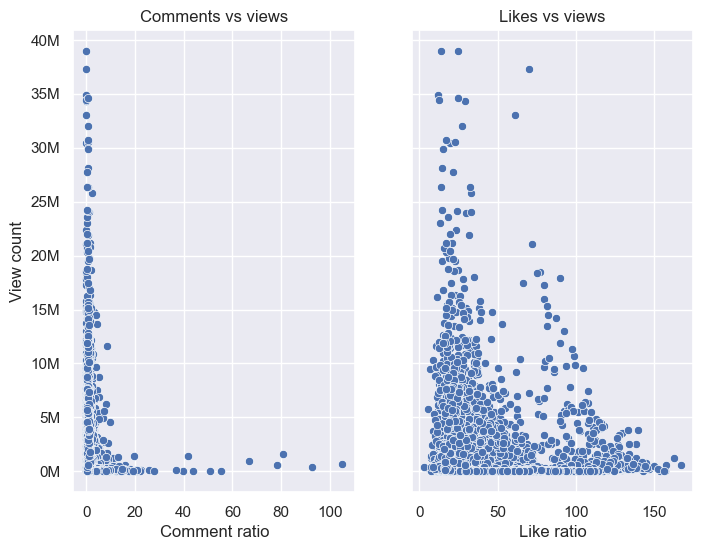

In [361]:
# Create figures
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

# Like and comment ratio vs view count scatter plots
sns.scatterplot(data = video_df, x = 'comment_ratio', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_ratio', y = 'view_count', ax = ax[1])

# Titles and labels
ax[0].set(xlabel='Comment ratio', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like ratio', ylabel='View count', title='Likes vs views')

# Format for the shared 'y' axis
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

With the scatter plot for ratios, it can be seen above that the previously apparent correlations become less noticeable.


Additionally, the plots show that:
- The connection between **comments and views** appears to decrease drastically. Many videos accumulate millions of views yet receive relatively few comments, while some videos with fewer views show higher interaction levels.
    - This can be attributed due to the fact that leaving comments demands more effort compared to simply viewing or liking a video. 
    - Additionally, people tend to stop commenting a video after it ages.

- The relationship between **likes and views** still exhibits a subtle but discernible positive correlation. This suggests that as a video's view count increases, so does the likelihood of viewers hitting the like button. 
    - This observation aligns with the concept of *social proof*, where people tend to favor products- or in this case content- that already have a substantial following, which suggests that popularity generates further approval. For the project this means that an already highly liked video may attract even more likes.

#### The impact of video length on views and engagement (likes/comments)
As shown in the histogram below, the majority of videos fall within the ranges of:
- 0 to 100 seconds, which are equivalent to 0 to 1 minute and 40 seconds. Most of these videos might be YouTube shorts.
- 300 to 600 seconds, which are equivalent to 5 to 10 minutes.

It's worth noting that I put a limit in the analysis to a maximum of 10,000 seconds (2 hours and 46 minutes) because of a few exceptionally long videos, possibly related to livestreams.

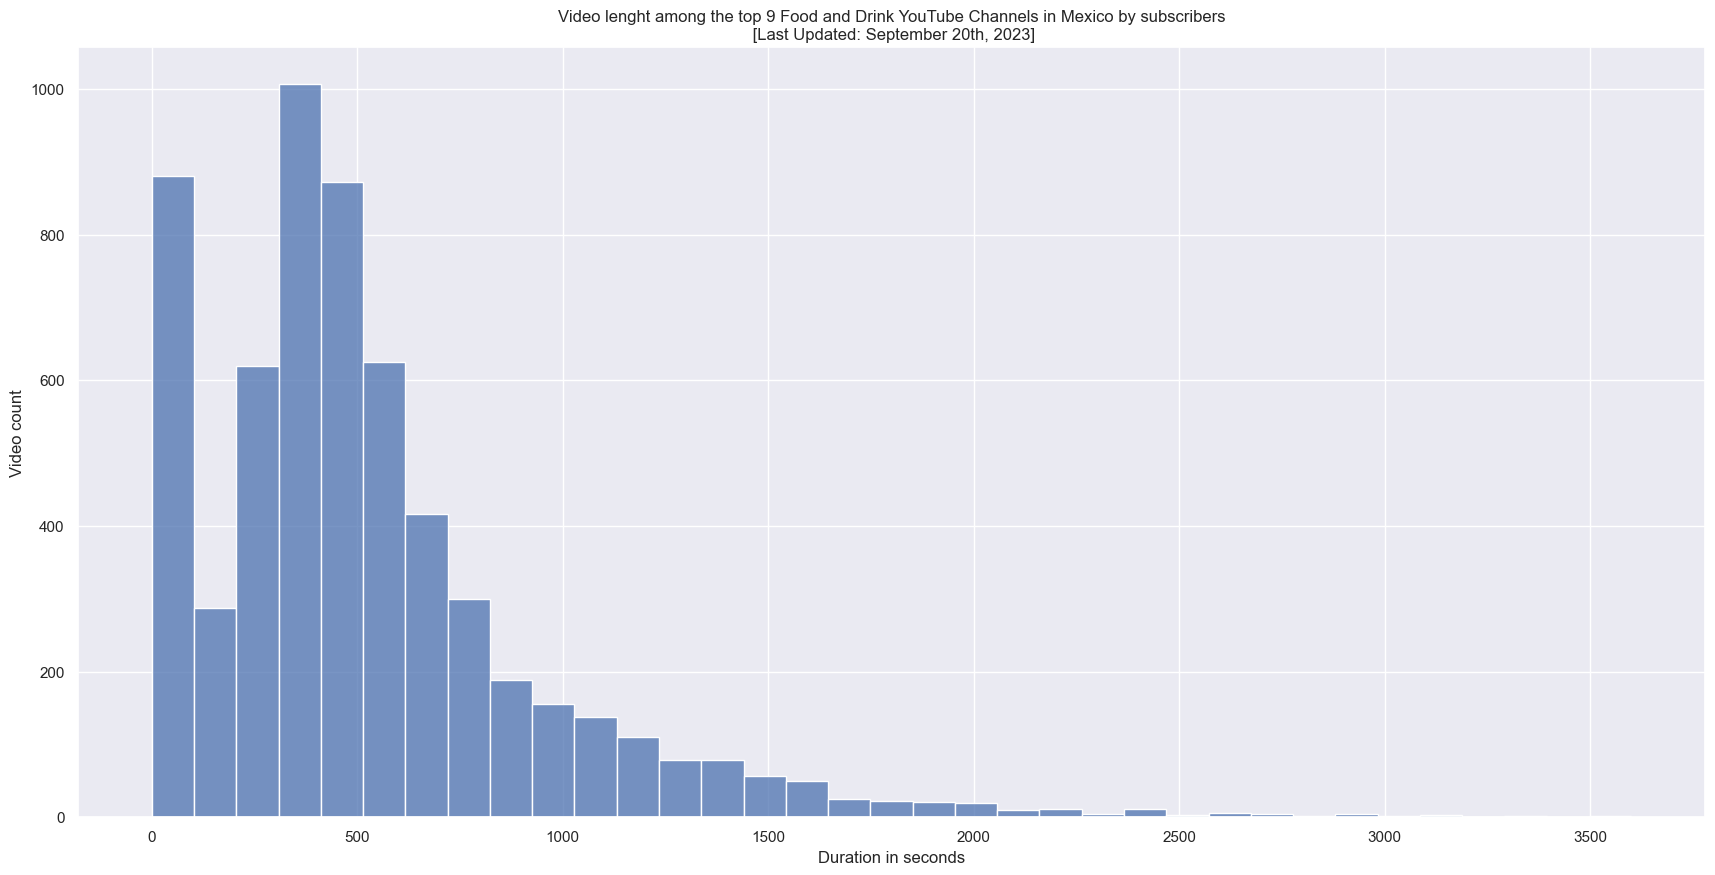

In [362]:
# Histogram of video count and duration in seconds
ax= sns.histplot(data=video_df[video_df['duration_secs'] < 10_000], x="duration_secs", bins=35, binrange=(0, 3_600))

# Labels and title
ax.set(xlabel='Duration in seconds', ylabel='Video count', title='Video lenght among the top 9 Food and Drink YouTube Channels in Mexico by subscribers\n [Last Updated: September 20th, 2023]');

Below I created plots comparing video duration to the number of comments and likes. Both plots reveal that shorter videos tend to have a higher engagement (more likes and comments) compared to significantly longer ones.

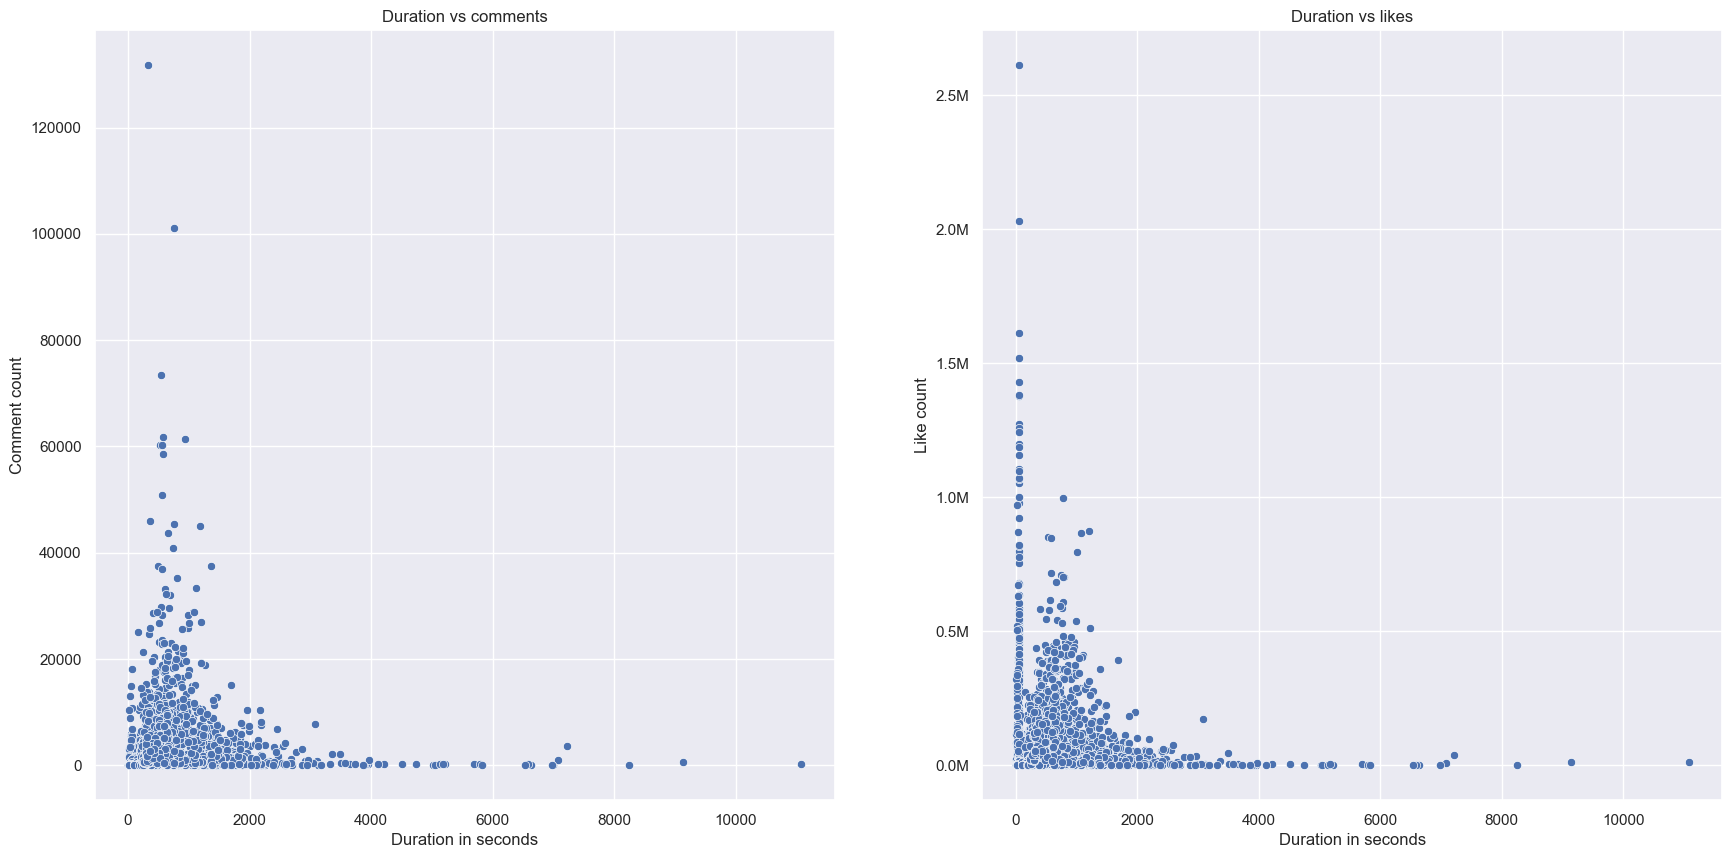

In [363]:
# Create figures
fig, ax =plt.subplots(1,2)

# Like and comment count vs duration in seconds scatter plots
sns.scatterplot(data = video_df, x = "duration_secs", y = "comment_count", ax=ax[0])
sns.scatterplot(data = video_df, x = "duration_secs", y = "like_count", ax=ax[1])

# Titles and labels
ax[0].set(xlabel='Duration in seconds', ylabel='Comment count', title='Duration vs comments')
ax[1].set(xlabel='Duration in seconds', ylabel='Like count', title='Duration vs likes')

# Formats for the 'x' axis in the ax[1]
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

#### Title lenght influence on views
While the scatterplot below doesn't show a discernible connection between title length and views, it's noteworthy that the most-viewed videos typically feature titles of moderate length, ranging from more than 20 to less than 80 characters.

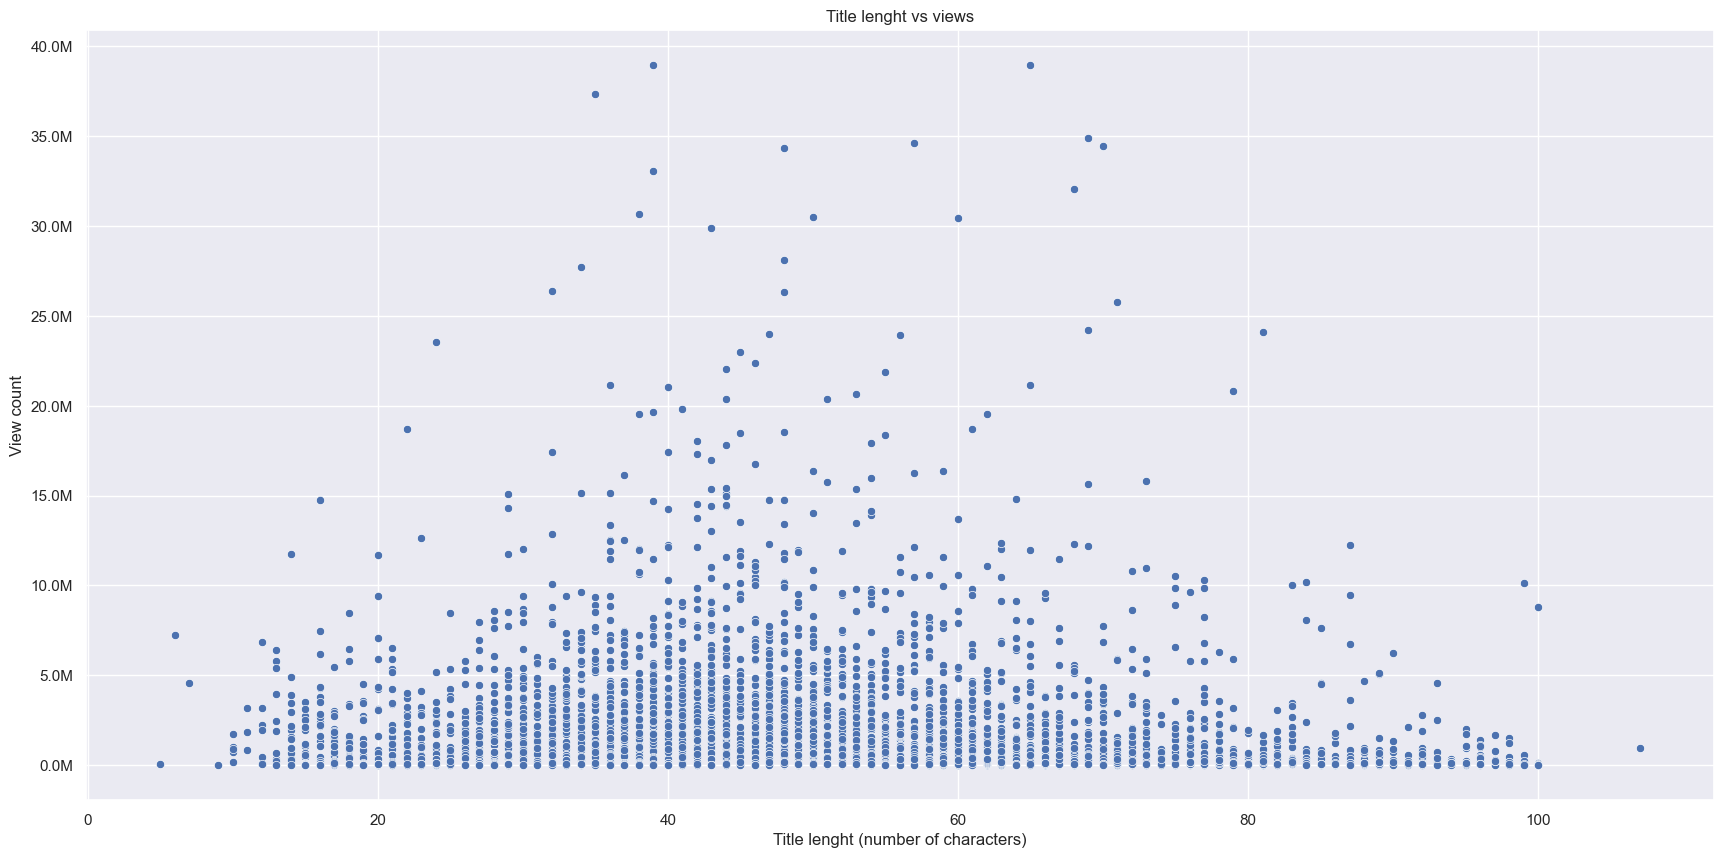

In [364]:
# Scatter plot of title lenght vs views
ax = sns.scatterplot(data = video_df, x = "title_length", y = "view_count")

# Title and labels
ax.set(xlabel= 'Title lenght (number of characters)', ylabel= 'View count', title='Title lenght vs views')

# Format for the 'x' axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

### Word cloud for video titles
As I'm curious about the content topics of the creators and which terms are most prevalent in their video titles, I'll generate a wordcloud to highlight the frequently used words. To achieve this, I'll begin by eliminating stopwords in spanish like 'El', 'La' and others, and also words from the names of the channels like 'Mis' and 'Pastelitos' as they don't significantly contribute to the title's meaning.

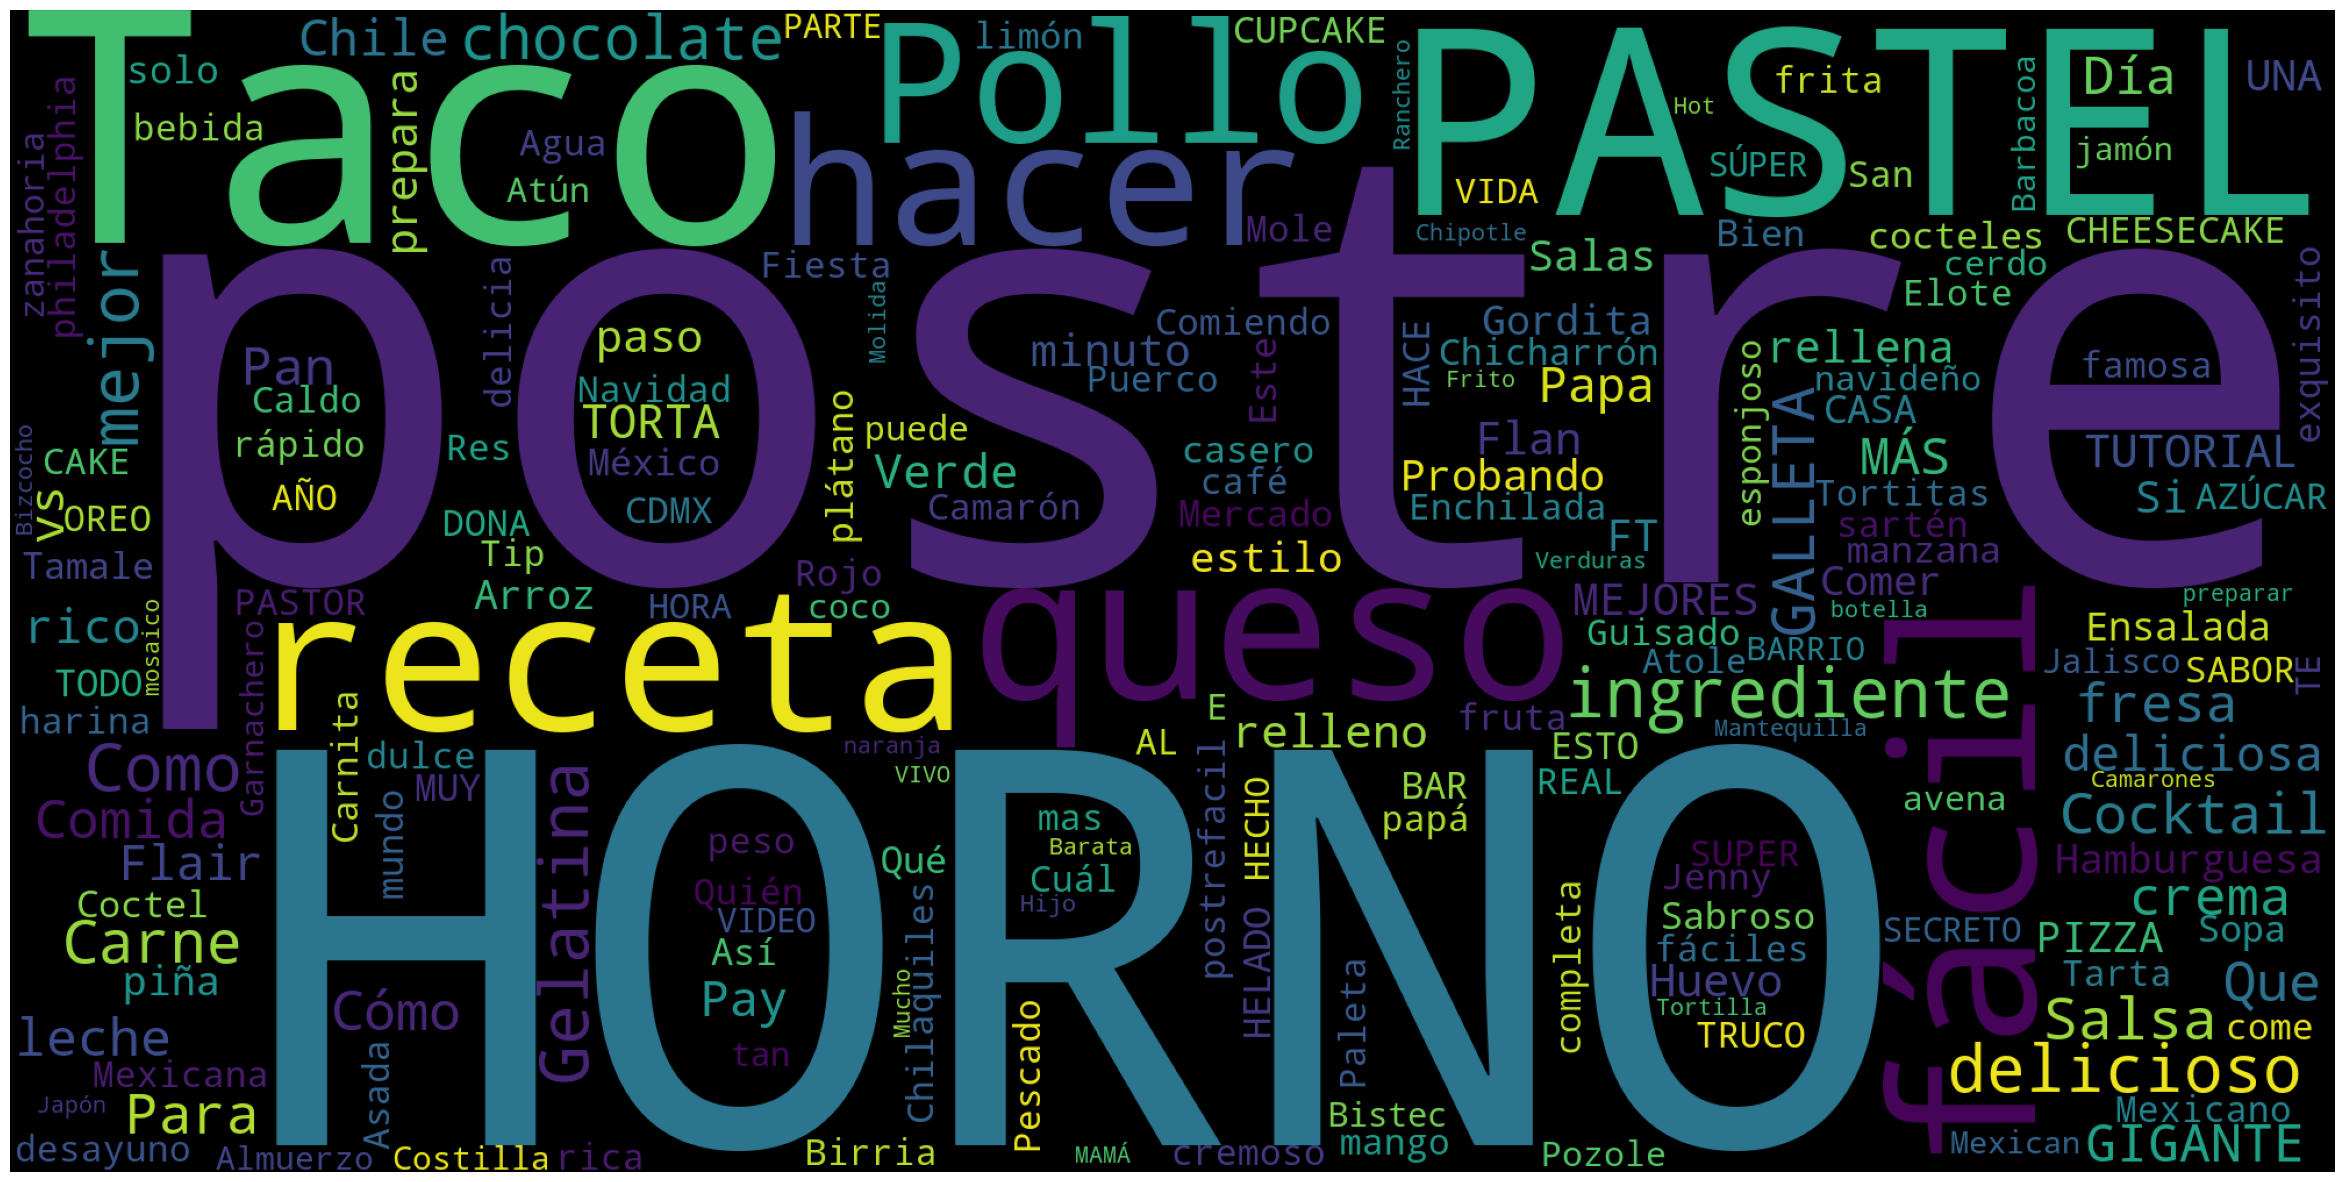

In [365]:
# Custom Spanish stopwords list
custom_spanish_stopwords = set([
    'Mis',
    'Pastelito',
    'Pastelitos',
    'El',
    'Guzii',
    'Marisolpink',
    'Bartender',
    'De',
    'Mi',
    'Rancho',
    'Tu',
    'Cocina',
    'La',
    'Capital',
    'Garnacha',
    'DondeiniciaMexicoLRG',
    'En',
    'Sin',
    'Con',
    'Y',
    'Ya',
    'Short',
    'Shorts',
    'Esta',
    'Por',
    'MiniSizeMe',
    'Lo',
    'Los',
    'La',
    'Las',
    'Le',
    'Un',
    'Del',
    'Se'
])

# Existing stopwords in Spanish
stop_words = set(stopwords.words('spanish'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

# Combine custom stopwords with any existing stopwords
all_spanish_stopwords = custom_spanish_stopwords.union(set(STOPWORDS))

# Generate the WordCloud
wordcloud = WordCloud(
    width=2000,
    height=1000,
    random_state=1,
    background_color='black',
    colormap='viridis',
    collocations=False,
    stopwords=all_spanish_stopwords  # Use the custom Spanish stopwords
).generate(all_words_str)

plot_cloud(wordcloud)


As seen above, the most utilized words in the titles are: *postre*, *horno*, *taco*, *pastel*, *receta*, *fácil*, *queso*, *pollo*, *hacer* (dessert, oven, taco, recipe, easy, cheese, chicken, make). 

It is not surprising to see those words in the niche of Mexican food and drink videos and tutorials.

### Number of tags vs views
- It seems that the majority of videos include a range of 5 to approximately 30 tags.
- While there isn't a distinct connection between the number of tags and view count, there does appear to be a correlation where both too few tags and too many tags are associated with lower view counts. With the exception of 0 tags.

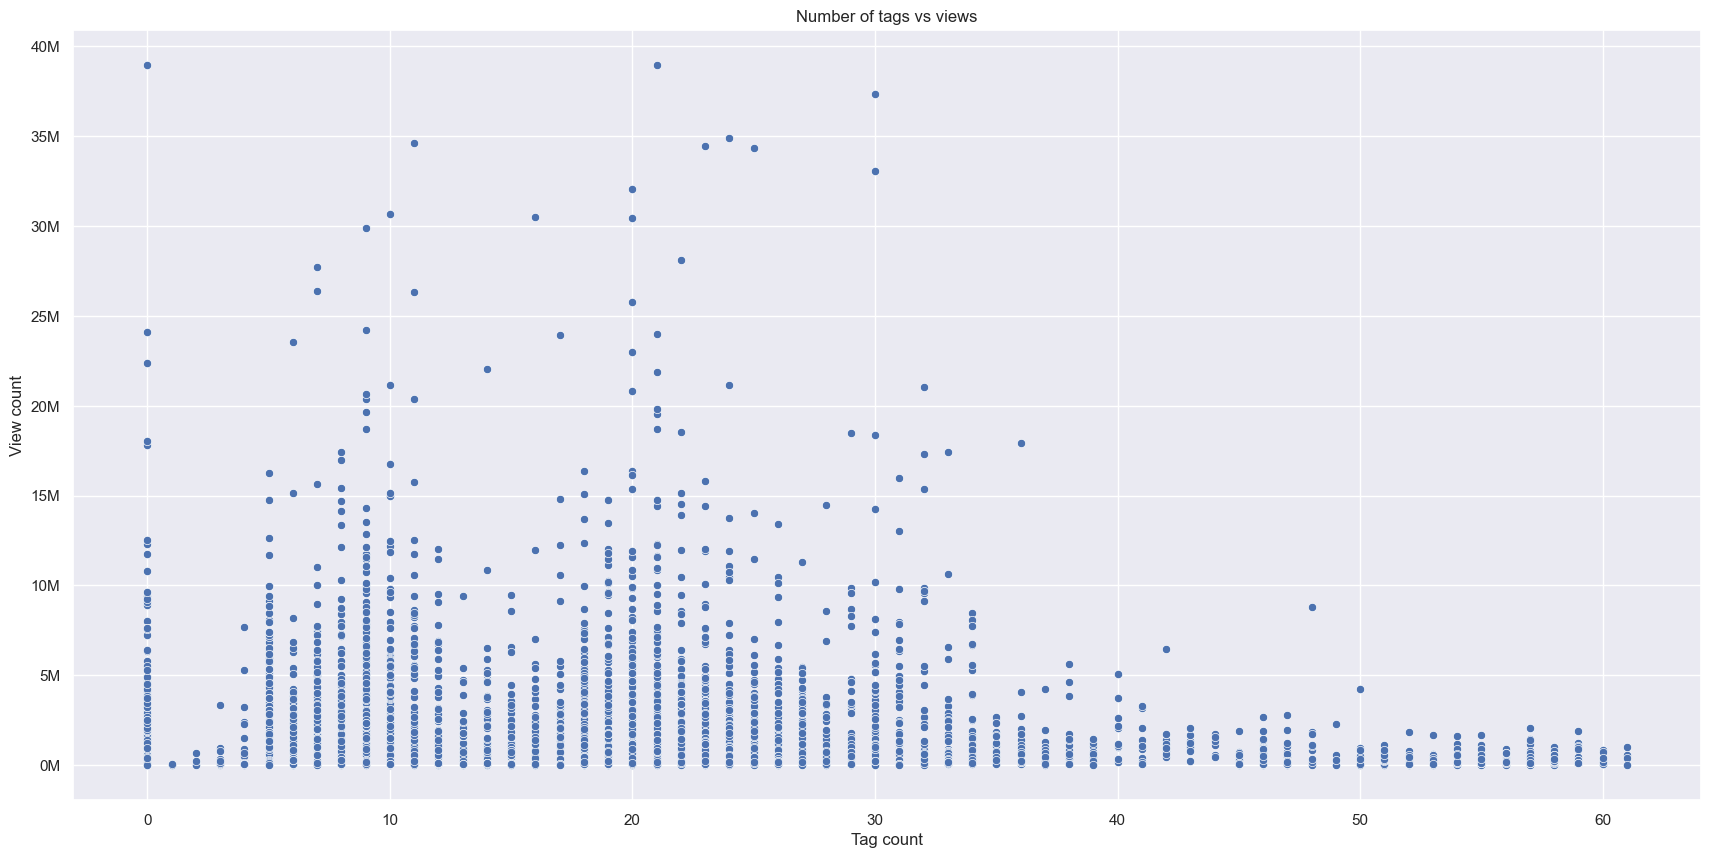

In [366]:
# Scatter plot of the number of tags vs views
ax = sns.scatterplot(data = video_df, x = 'tag_count', y = 'view_count')

# Title and labels
ax.set(xlabel= 'Tag count', ylabel= 'View count', title='Number of tags vs views')

# Format for the 'x' axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

### Update schedule
Most video uploads occur on Tuesdays and Thursdays, while fewer videos are posted during the weekend. This trend could be attributed to:
- The content niche, which may focus more on tutorials and material less suited for weekend consumption. People tend to order more takeout food or go to restaurants on the weekends, so those days they may be less incentivated to learn how to cook a certain dish.
- The creators, who might dedicate their weekends to create the videos and subsequently release them over the week.


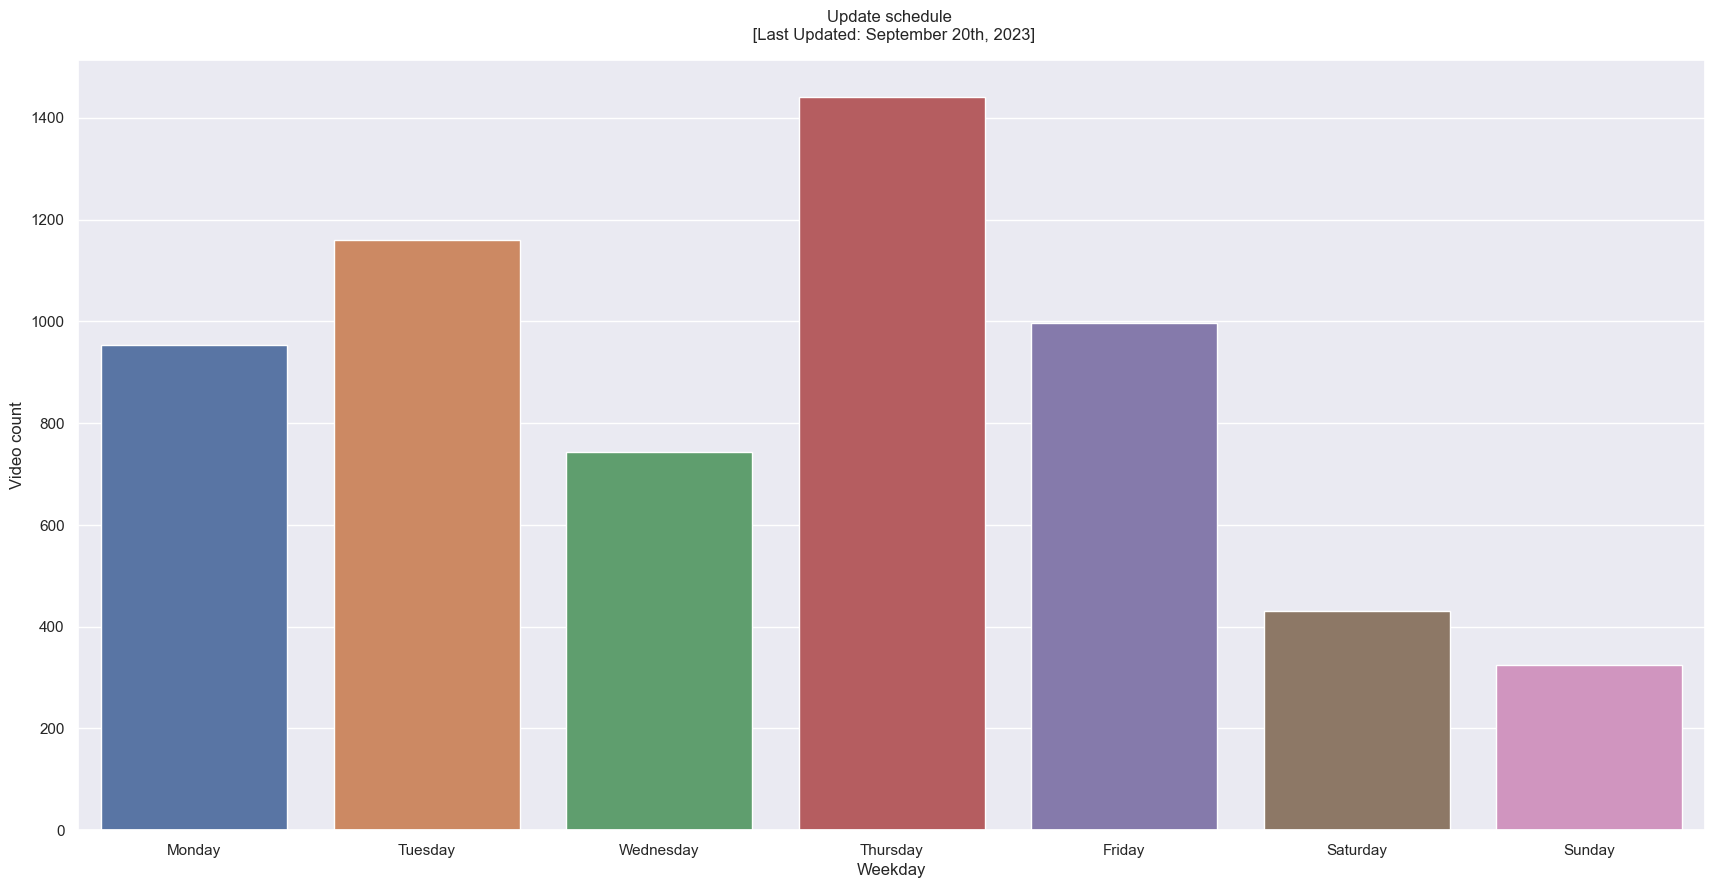

In [367]:
# Count quantity of videos and classify by weekday
day_df = pd.DataFrame(video_df['published_day_name'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

# Bar plot for the update schedule
ax = sns.barplot(x = 'index', y = 'published_day_name', data = day_df.reset_index())

# Labels and title
ax.set_xlabel('Weekday')
ax.set_ylabel('Video count')
plt.title('Update schedule \n [Last Updated: September 20th, 2023]', pad= 15);